Train: (159, 13), Val: (53, 13), Test: (91, 13)
Blending Accuracy: 81.319
0.8129251700680273
[[40  9]
 [ 8 34]]


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


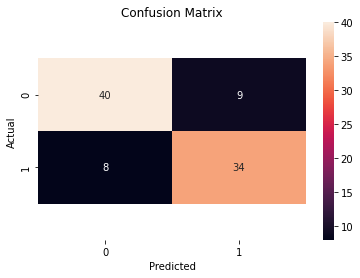

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# blending ensemble for classification using hard voting
from numpy import hstack
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier
 
# get the dataset
def get_dataset():
	#X, y = make_classification(n_samples=10000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
	data_set= pd.read_csv('C:/Users/user/Downloads/heart_disease_dataset.csv')
	#Extracting Independent and dependent Variable  
	#print(data_set.shape)
	X= data_set.iloc[:, :-1].values  
	y= data_set.iloc[:, 13].values
	return X, y

# get a list of base models
def get_models():
	models = list()
	models.append(('lr', LogisticRegression()))
	models.append(('knn', KNeighborsClassifier()))
	models.append(('cart', DecisionTreeClassifier()))
	models.append(('svm', SVC()))
	models.append(('bayes', GaussianNB()))
	return models
 
# fit the blending ensemble
def fit_ensemble(models, X_train, X_val, y_train, y_val):
	# fit all models on the training set and predict on hold out set
	meta_X = list()
	for name, model in models:
		# fit in training set
		model.fit(X_train, y_train)
		# predict on hold out set
		yhat = model.predict(X_val)
		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		#print(yhat)
		#print(len(yhat))
		#exponential noise
		mn=yhat.mean()
		v=yhat.std()
		s=1/0.01 #epsilon=0.001
		n=np.random.normal(mn,v,(len(yhat), 1))
		#print(n)
		yhat = yhat.reshape(len(yhat), 1) + n
		#yhat = yhat.reshape(len(yhat), 1)
		#print(yhat)
		# store predictions as input for blending
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = hstack(meta_X)
	# define blending model
	blender = LogisticRegression()
	# fit on predictions from base models
	blender.fit(meta_X, y_val)
	return blender
 
# make a prediction with the blending ensemble
def predict_ensemble(models, blender, X_test):
	# make predictions with base models
	meta_X = list()
	for name, model in models:
		# predict with base model
		yhat = model.predict(X_test)
		# reshape predictions into a matrix with one column
		yhat = yhat.reshape(len(yhat), 1)
		# store prediction
		meta_X.append(yhat)
	# create 2d array from predictions, each set is an input feature
	meta_X = hstack(meta_X)
	# predict
	return blender.predict(meta_X)
 
# define dataset
X, y = get_dataset()
# split dataset into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
# split training set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=1)
# summarize data split
print('Train: %s, Val: %s, Test: %s' % (X_train.shape, X_val.shape, X_test.shape))
# create the base models
models = get_models()
# train the blending ensemble
blender = fit_ensemble(models, X_train, X_val, y_train, y_val)
# make predictions on test set
yhat = predict_ensemble(models, blender, X_test)
# evaluate predictions
score = accuracy_score(y_test, yhat)
print('Blending Accuracy: %.3f' % (score*100))
print(roc_auc_score(y_test, yhat))
#Creating the Confusion matrix  
from sklearn.metrics import confusion_matrix  
cm= confusion_matrix(y_test, yhat) 
print(cm)
# visualize Confusion Matrix
fig = sns.heatmap(cm, annot=True, fmt="d")
bottom, top = fig.get_ylim()
fig.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()